# Plotting the Wind on Berwick Law

This Notebook is to summarize all the code used to visualize and analyze the wind patterns on Berwick Law.

In [1]:
# Import all the necessary libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
from windrose import WindroseAxes
import warnings
import matplotlib

warnings.filterwarnings('ignore')


## Linear wind model

$$
z_{ij}=\frac{100}{1 + (r_{ij}/50)^2}
$$
with $r_{ij} = |i|$ for a ridge or $r_{ij} = \sqrt{i^2 + j^2}$ for a hill (-256 $<i,j<$ 255).



In [2]:
# Parameters
topo_file = 'data/NorthBerwickLawBlend1.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

In [3]:
# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

def wind_model(n,zr):
    Fz = fft2(zr)
    Fz = fftshift(Fz)

    # Wavenumbers and modified Bessel functions
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
    bu[int(n/2)] = 0
    bv[int(n/2)] = 0

    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r != 0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    ur = 1 + np.real(ifft2(Fu))
    vr = np.real(ifft2(Fv))
    windr = np.sqrt(ur**2 + vr**2)
    
    # Vertical wind component from continuity equation
    wr = np.zeros_like(windr)
    dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
    dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
    wr[1:-1,1:-1] = ur[1:-1,1:-1]*dzdx + vr[1:-1,1:-1]*dzdy
    
    return ur, vr, wr, windr

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file)
n = z.shape[0]

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

u, v, w, wind = wind_model(n,z)

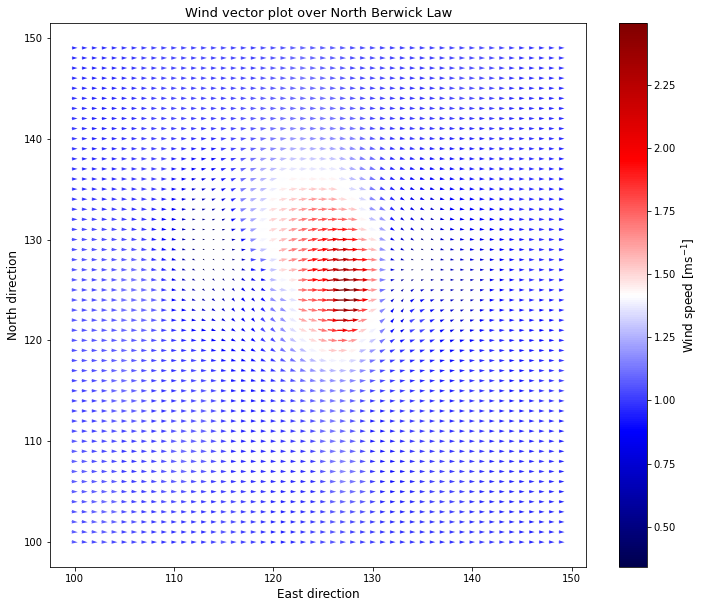

"Probably won't keep it"

In [4]:
# Wind vector plot over hill

X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 10))
#create quiver plot of data

q = ax.quiver(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], wind[100:150, 100:150], cmap='seismic', pivot='mid', units='inches')

# set colourbar for the plot
cbar = fig.colorbar(q)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind vector plot over North Berwick Law", fontsize = 13)
ax.set_xlabel("East direction", fontsize=12)
ax.set_ylabel("North direction", fontsize=12)
plt.show()
# is the wind speed in m/s?
'''Probably won't keep it'''

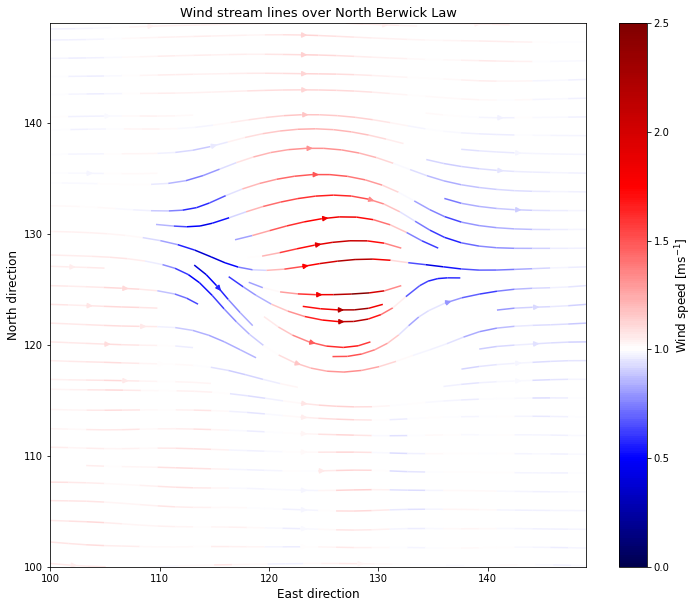

In [5]:
# Wind stream lines over hill

#create stream plot

fig, ax = plt.subplots(figsize=(12, 10))
strm = ax.streamplot(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], color=wind[100:150, 100:150], 
                     cmap='seismic', norm=matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=2.5))

#set colourbar according to wind speed
cbar = fig.colorbar(strm.lines)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind stream lines over North Berwick Law", fontsize = 13)
ax.set_xlabel("East direction", fontsize = 12)
ax.set_ylabel("North direction", fontsize = 12)

plt.show()

In [6]:
# Finding the minimum and maximum wind speed
print(wind.min())
print(wind.max())

0.34109544828657035
2.493387764469251


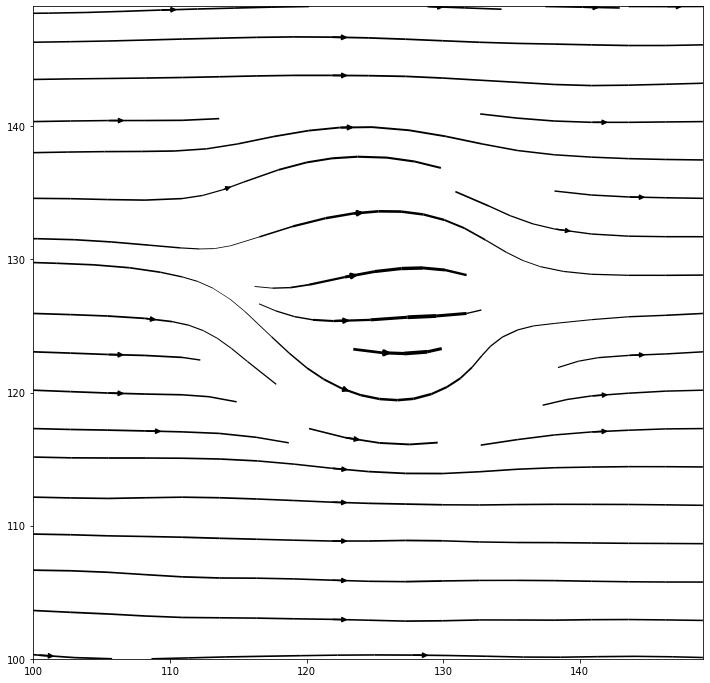

"Probably won't keep it"

In [7]:
# Vary wind stream linewidth with wind speed

# simple code
X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 12))

# set linewidth dependent on wind speed
lw = 4 * wind[100:150, 100:150] / (wind[100:150, 100:150].max())

ax.streamplot(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], density=0.6, color='k', linewidth=lw)
ax.set_xlabel

plt.show()
'''Probably won't keep it'''

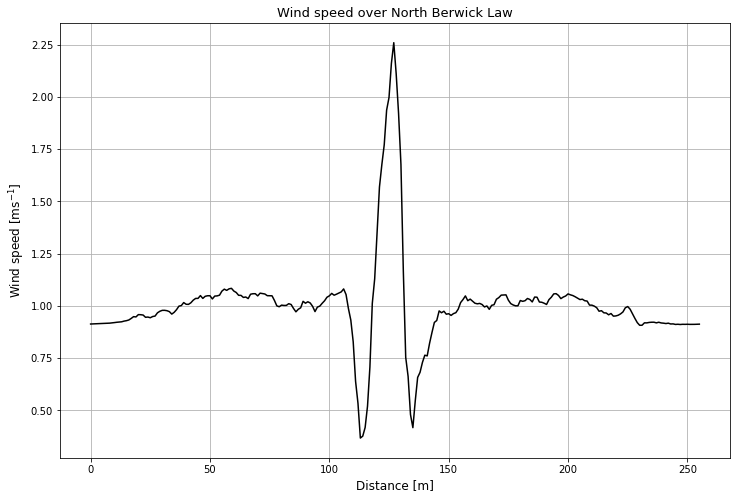

In [8]:
# Wind speed over top of hill
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(wind[128,:], c = "k")
ax.set_title("Wind speed over North Berwick Law", fontsize = 13)
ax.set_xlabel("Distance [m]", fontsize = 12)
ax.set_ylabel("Wind speed [ms$^{-1}$]", fontsize = 12)
ax.grid()

### Plotting vertical component of wind

Text(0.5, 1.0, 'Vertical wind component over summit of North Berwick Law')

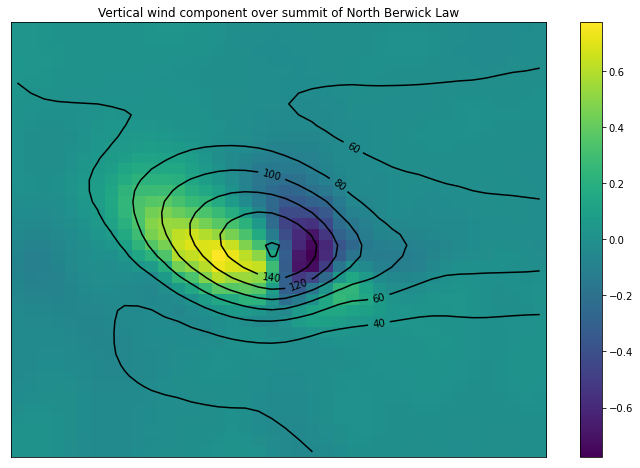

In [9]:
# Plot vertical wind component and topography for 1 km x 1 km area centred on the summit
plt.figure(figsize=(12,8))
plt.imshow(w[int(n/2)-20:int(n/2)+20,int(n/2)-20:int(n/2)+20],origin='lower', aspect='auto')  # north at the top of the image
plt.colorbar()
cs = plt.contour(z[int(n/2)-20:int(n/2)+20,int(n/2)-20:int(n/2)+20],colors='k',levels=np.arange(0,1000,20))
plt.clabel(cs,fmt='%d')
plt.xticks([])
plt.yticks([])

plt.title("Vertical wind component over summit of North Berwick Law")



#  3D wind speed plots
## Wind speed vector


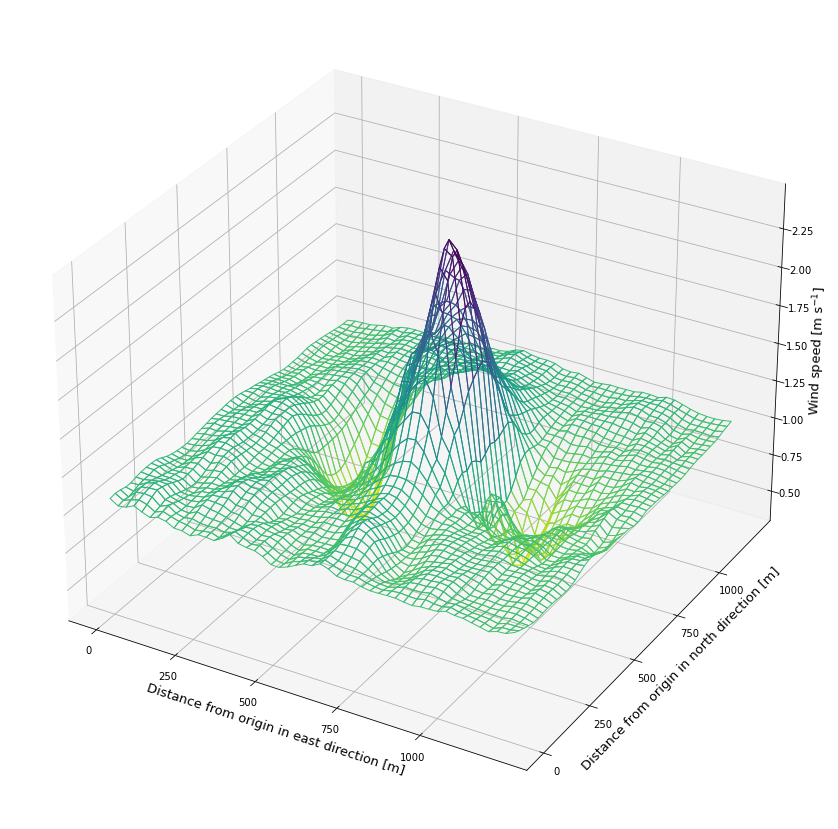

In [10]:
# Wind speed 3d plot around the hill

from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

#%matplotlib notebook
def surface_plot(data):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 50)
    y = np.arange(0, 50)
    X, Y = np.meshgrid(x, y)

    # Normalize to [0,1]
    Z = data[100:150, 100:150]
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis_r(norm(Z))
    rcount, ccount, _ = colors.shape
    

    surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                           facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    


    ax.set_xlabel('Distance from origin in east direction [m]', fontsize=13)
    ax.set_ylabel('Distance from origin in north direction [m]', fontsize=13)
    ax.set_zlabel('Wind speed [m s$^{-1}$]', fontsize=13)
    plt.xticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    plt.yticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    #ax.set_title("3D plot of wind speed around North Berwick Law", fontsize=14)
    #ax.view_init(30, 110) # change the viewing angle
    
surface_plot(wind)


## Vertical component of wind speed

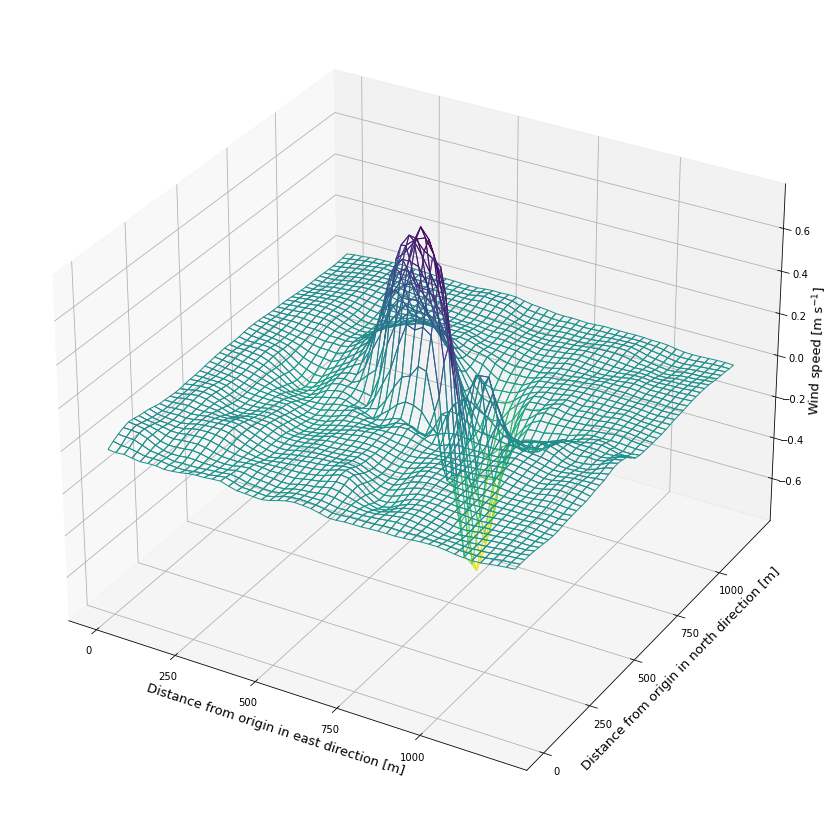

In [11]:
# 3D plot of Vertical wind speed component (w)

surface_plot(w)

"Probably won't keep it"

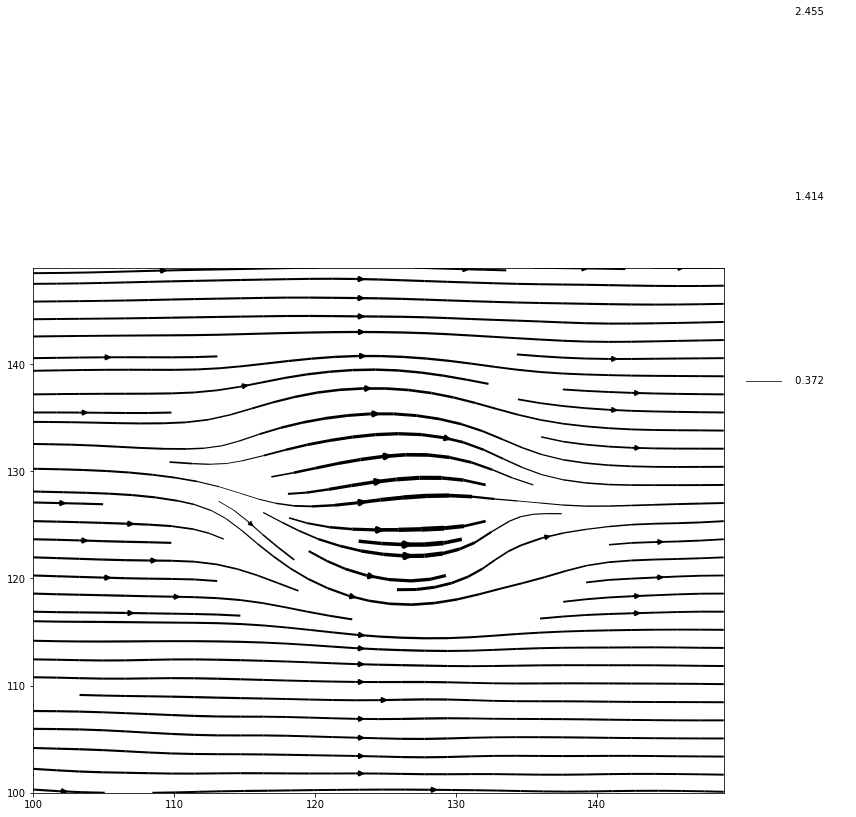

In [12]:
## Not sure if using plots below

# More sophisticated model for varying stream linewidth with wind speed
import matplotlib.gridspec as gridspec

# Create your figure
fig = plt.figure(figsize=(12, 12))

# Create axes, ax for your plot, and lx for the legend
gs = gridspec.GridSpec(2, 2, height_ratios=(1,2), width_ratios=(6,1))
ax = fig.add_subplot(gs[:, 0])
lx = fig.add_subplot(gs[0, 1])

def windToLW(wind):
    ''' 
    Function to convert windspeed into a sensible linewidth
    This function is somewhat arbitrary and has to be found by trail and error, so that it looks reasonable
    '''
    return wind * 2.

def LWToSpeed(lw):
    ''' The inverse of windToLW, to get the speed back from the linewidth '''
    return (lw) /2

def makeStreamLegend(strm, lx, convertFunc, nlines=5, color='k', fmt='{:g}'):

    ''' Make a legend for a streamplot on a separate axes instance '''

    # Get the linewidths from the streamplot LineCollection
    lws = np.array(strm.lines.get_linewidths())

    # Turn off axes lines and ticks, and set axis limits
    lx.axis('off')
    lx.set_xlim(0, 1)
    lx.set_ylim(0, 1)

    # Loop over the desired number of lines in the legend
    for i, y in enumerate(np.linspace(wind.min(), wind.max(), nlines)):

        # This linewidth
        lw = lws.min()+float(i) * lws.ptp()/float(nlines-1)
        
        # Plot a line in the legend, of the correct length
        lx.axhline(y, 0.1, 0.4, c=color, lw=lw)

        # Add a text label, after converting the lw back to a speed
        lx.text(0.5, y, fmt.format(convertFunc(lw)), va='center')
        
# Make the stream plot
strm = ax.streamplot(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], 
                     color="k", linewidth=windToLW(wind[100:150, 100:150]))

# Add a legend, with nlines lines
makeStreamLegend(strm, lx, LWToSpeed, nlines=3, fmt='{:6.3f}')
plt.tight_layout()

# did not manage to make labels as a tight format
'''Probably won't keep it'''

In [13]:
'''# Wind vector plot over hill
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

s = 110
e = 140
stp = 5

# Make the grid
X, Y, Z = np.meshgrid(np.arange(s, e, stp),
                      np.arange(s, e, stp),
                      np.arange(0, 30, stp))

# Plot 3D quiver plot
ax.quiver(X, Y, Z, u[s:e:stp, s:e:stp], v[s:e:stp, s:e:stp], w[s:e:stp, s:e:stp])

# maybe add the topogrpahy plot
# does not tell a lot
# don't think this is a meaningful plot'''

"# Wind vector plot over hill\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom mpl_toolkits.mplot3d import Axes3D\nfig = plt.figure(figsize=(12, 12))\nax = fig.gca(projection='3d')\n\ns = 110\ne = 140\nstp = 5\n\n# Make the grid\nX, Y, Z = np.meshgrid(np.arange(s, e, stp),\n                      np.arange(s, e, stp),\n                      np.arange(0, 30, stp))\n\n# Plot 3D quiver plot\nax.quiver(X, Y, Z, u[s:e:stp, s:e:stp], v[s:e:stp, s:e:stp], w[s:e:stp, s:e:stp])\n\n# maybe add the topogrpahy plot\n# does not tell a lot\n# don't think this is a meaningful plot"

In [14]:
"""
# 3D plots
from mpl_toolkits.mplot3d import Axes3D

# Vector plot over whole area
# Make the grid
X, Y, Z = np.meshgrid(np.arange(0, 256),
                      np.arange(0, 256),
                      np.arange(0, 256))

fig, ax = plt.subplots(figsize=(12, 12))
ax.quiver(X, Y, Z, u, v, w)

# does not tell a lot
"""

'\n# 3D plots\nfrom mpl_toolkits.mplot3d import Axes3D\n\n# Vector plot over whole area\n# Make the grid\nX, Y, Z = np.meshgrid(np.arange(0, 256),\n                      np.arange(0, 256),\n                      np.arange(0, 256))\n\nfig, ax = plt.subplots(figsize=(12, 12))\nax.quiver(X, Y, Z, u, v, w)\n\n# does not tell a lot\n'

In [15]:
#Winds calculated for N, S, E, NE, SE, SW, NW

# Use the functions to generate 4 subplots for the different wind directions

"""
The topography is rotated 
- by 90 degrees clockwise with np.flipud(A.T), 
- by 90 degrees anticlockwise with np.fliplr(A.T),
- by 180 degrees with np.flipud(np.fliplr(A.T))

The inverse of the rotation applied to the topography has to be applied to the separate wind components.
The u and v components also have to be swapped for 90 degree rotations.
"""

# Westerly wind
uw, vw, ww, windw = wind_model(n,z)

# Southerly wind
zrs = np.flipud(z.T)
urs, vrs, wrs, windrs = wind_model(n,zrs)
us = - np.fliplr(vrs.T)
vs = np.fliplr(urs.T)
winds = np.fliplr(windrs.T)

# Easterly wind
zre = np.flipud(np.fliplr(z))
ure, vre, wre, windre = wind_model(n,zre)
ue = - np.flipud(np.fliplr(ure))
ve = - np.flipud(np.fliplr(vre))
winde = np.flipud(np.fliplr(windre))

# Northerly wind
zrn = np.fliplr(z.T)
urn, vrn, wrn, windrn = wind_model(n,zrn)
un = np.flipud(vrn.T)
vn = - np.flipud(urn.T)
windn = np.flipud(windrn.T)

# South Westerly wind
usw = (us + uw)/2
vsw = (vs + vw)/2
windsw = np.sqrt(usw**2 + vsw**2)

# South Easterly wind
use = (us + ue)/2
vse = (vs + ve)/2
windse = np.sqrt(use**2 + vse**2)

# North Easterly wind
une = (un + ue)/2
vne = (vn + ve)/2
windne = np.sqrt(une**2 + vne**2)

#North Westerly wind
unw = (un + uw)/2
vnw = (vn + vw)/2
windnw = np.sqrt(unw**2 + vnw**2)

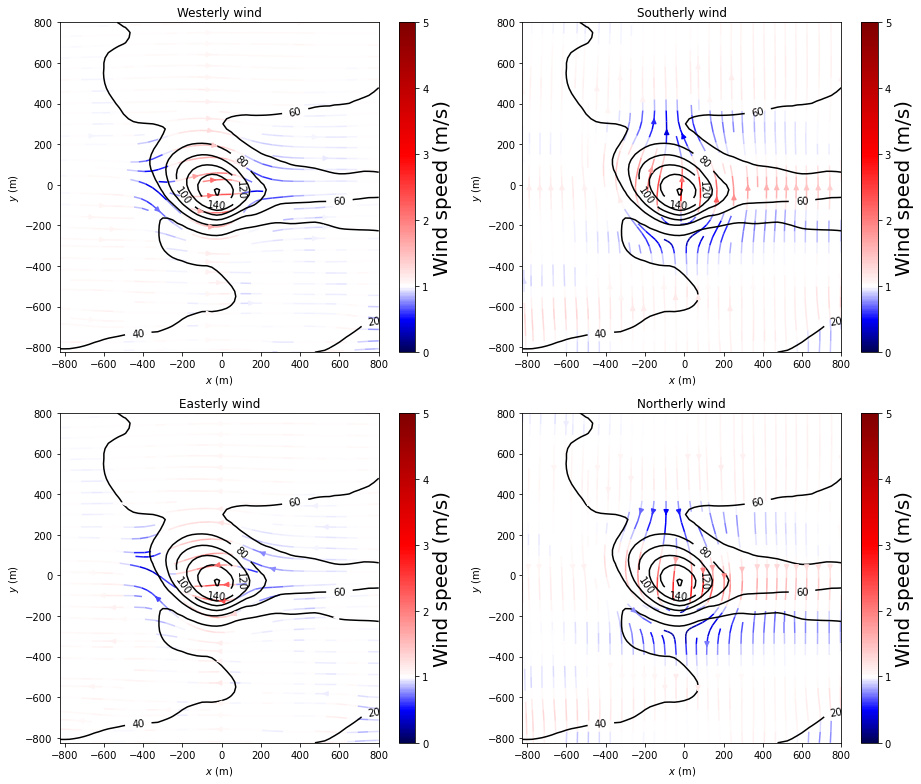

In [16]:
#Plotting wind from different directions
#N,S,E

def plot_wind(u,v,wind,z,title, col_bar_min=0, col_bar_max=5, extension='neither'):
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.streamplot(x[95:161],y[95:161],u[95:161,95:161],v[95:161,95:161],
                   color=wind[95:161,95:161],cmap='seismic',
                   norm=matplotlib.colors.TwoSlopeNorm(vmin=col_bar_min, vcenter=1, vmax=col_bar_max))
    plt.colorbar(extend=extension).set_label(label='Wind speed (m/s)', size=20)
    cs = plt.contour(x[95:161],y[95:161],z[95:161,95:161],colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)
    
plt.figure(figsize=(13, 11))

# Westerly wind
plt.subplot(221)
plot_wind(uw,vw,windw,z,'Westerly wind')

# Southerly wind
plt.subplot(222)
plot_wind(us,vs,winds,z,'Southerly wind')

# Easterly wind
plt.subplot(223)
plot_wind(ue,ve,winde,z,'Easterly wind')

# Northerly wind
plt.subplot(224)
plot_wind(un,vn,windn,z,'Northerly wind')

plt.tight_layout()

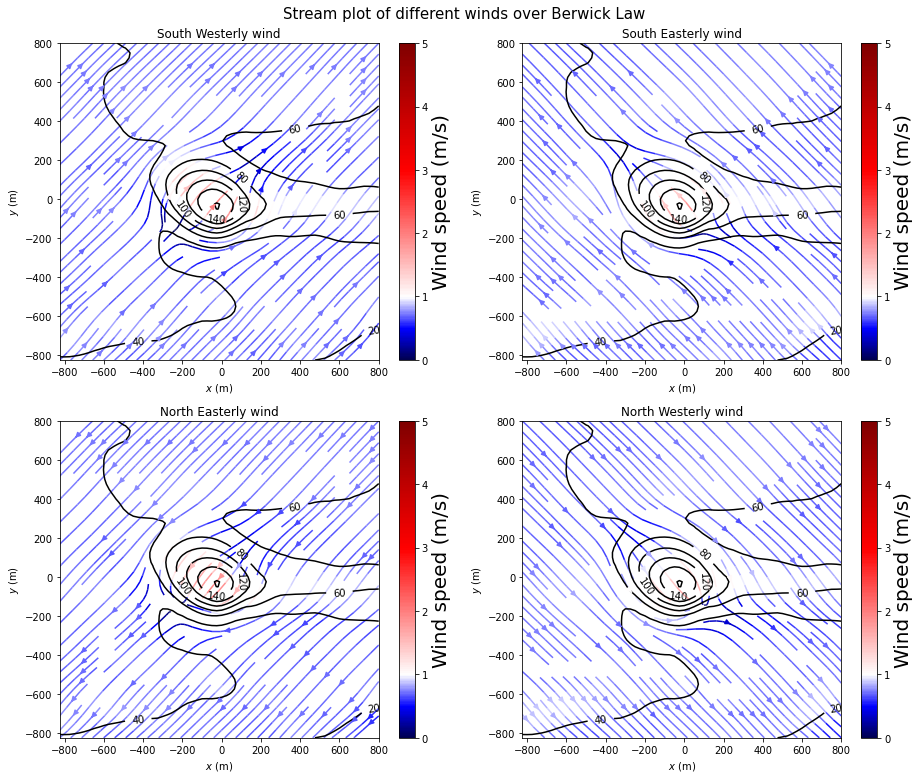

In [17]:
plt.figure(figsize=(13, 11))

# South Westerly wind
plt.subplot(221)
plot_wind(usw, vsw, windsw, z, 'South Westerly wind')

# South Easterly wind
plt.subplot(222)
plot_wind(use, vse, windse, z, 'South Easterly wind')

# North Easterly wind
plt.subplot(223)
plot_wind(une, vne, windne, z, 'North Easterly wind')

# North Westerly wind
plt.subplot(224)
plot_wind(unw, vnw, windnw, z, 'North Westerly wind')

plt.suptitle("Stream plot of different winds over Berwick Law", fontsize = 15)
plt.tight_layout()

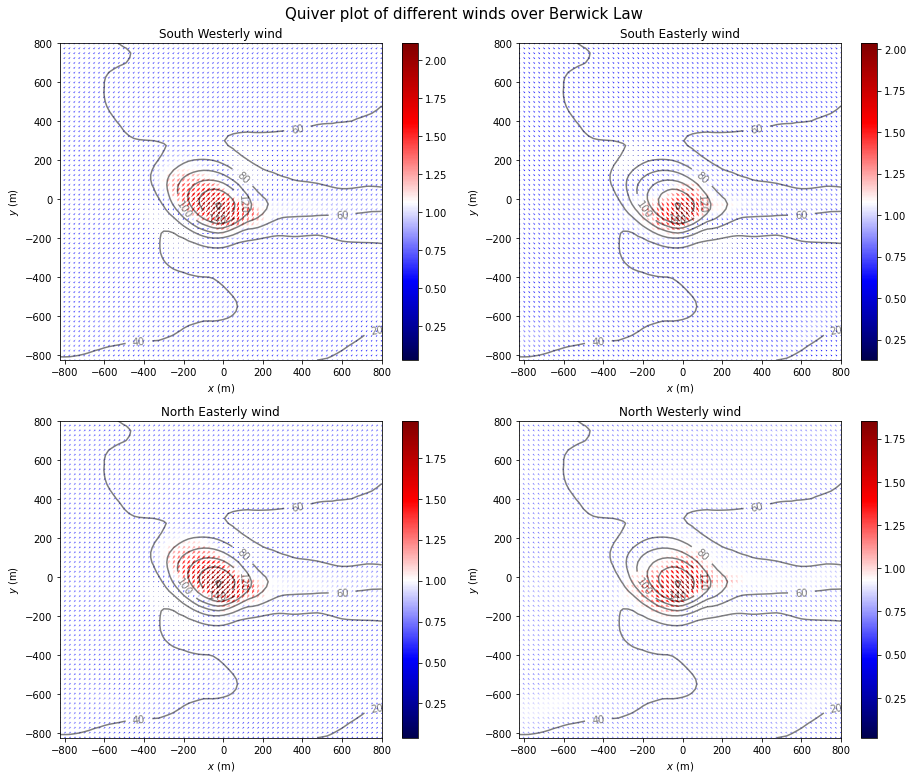

In [18]:
def quiver_wind(u,v,wind,z,title):
    """
    Input:
    - u, v: wind components
    - wind: overall wind
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.quiver(x[95:161],y[95:161],u[95:161,95:161],v[95:161,95:161], wind[95:161,95:161], linewidth = 30, 
               cmap='seismic', pivot='mid', units='inches')
    plt.colorbar()
    #plt.clim(0, 3)
    cs = plt.contour(x[95:161],y[95:161],z[95:161,95:161],alpha = 0.5, colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

plt.figure(figsize=(13, 11))

# South Westerly wind
plt.subplot(221)
quiver_wind(usw,vsw,windsw,z,'South Westerly wind')

# South Easterly wind
plt.subplot(222)
quiver_wind(use,vse,windse,z,'South Easterly wind')

# North Easterly wind
plt.subplot(223)
quiver_wind(une,vne,windne,z,'North Easterly wind')

# North Westerly wind
plt.subplot(224)
quiver_wind(unw,vnw,windnw,z,'North Westerly wind')

plt.suptitle("Quiver plot of different winds over Berwick Law", fontsize = 15)
plt.tight_layout()

## Windrose plots
Plotting the wind directions for North Berwick, Blackford hill and Gogarbank on a windrose plot to show frequency of wind directions and speeds.

How to read a windrose plot:
- theta axis is wind direction (where wind is coming from)
- r axis is frequency of that wind direction in %
- colormap is for the wind speeds in m/s

### North Berwick
The windrose analyses the distribution of wind directions and speeds due to the influence of Berwick Law. The wind is originally westerly and has a speed of 1m/s. The windrose shows the distribution of wind at one point in time. If the hill had no effect, 100% of the wind would come from the west at 1m/s. But it is deflected and sped up/slowed down on different parts of the hill. Only a 30x30 grid was selected to analyse the wind, where x and y are 110-140, because that is where the hill is located.

### Gogarbank
The windrose analyses the distribution of wind directions and speeds based on hourly data in 2014. It shows a mostly SW wind, which means that our model analysing the wind flow for a westerly wind over Berwick Law is reasonable.

*Maybe analyse what time of year we get westerly winds?*

### Blackford hill
The windrose analyses the distribution of wind directions and speeds based on hourly data in 2014. It shows a mostly W-SW wind, which means that our model analysing the wind flow for a westerly wind over Berwick Law is reasonable.

*Maybe analyse what time of year we get westerly winds?*

**Note: when we have the JCMB data, average that to somewhere between 1min and 1h to check for stability - in order to determine the length of the measurements future yearsneed to take**

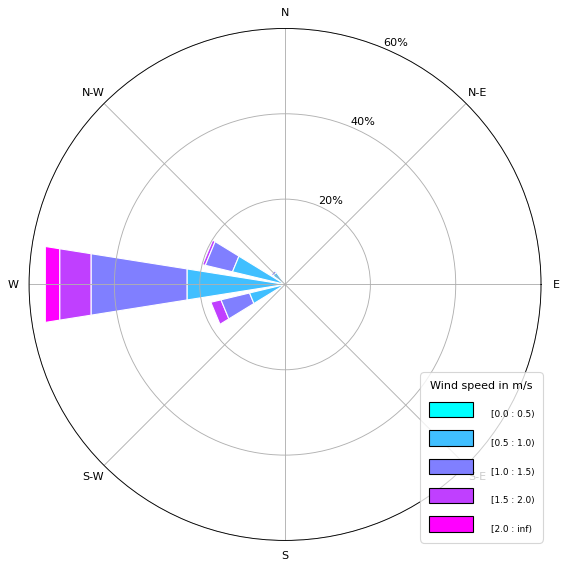

In [19]:
#Berwick Law

## Calculating the wind direction (where wind is blowing from)
wdir=np.mod(180+np.rad2deg(np.arctan2(u, v)),360)

## Creating the windrose axis - x-axis (theta axis) is wind directions
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]                   
ax = WindroseAxes.from_ax(theta_labels=new_labels)

## Plotting the speeds and directions on the windrose
ax.bar( wdir[110:140, 110:140].flatten(), 
       wind[110:140, 110:140].flatten(),
       normed=True, opening=0.8, edgecolor='white', cmap=cm.cool,
       bins=np.arange(0, 2.5, 0.5)) # Bins for the wind speed

## y axis (r axis) is thefrequency of a certain wind direction in percent
ax.set_ylim(0,60)
ax.set_yticks(np.arange(0, 70, 20))
ax.set_yticklabels(['', '20%', '40%', '60%'], size=10)

## Legend of wind speeds
ax.set_legend(title='Wind speed in m/s', fontsize=20, loc='lower right')

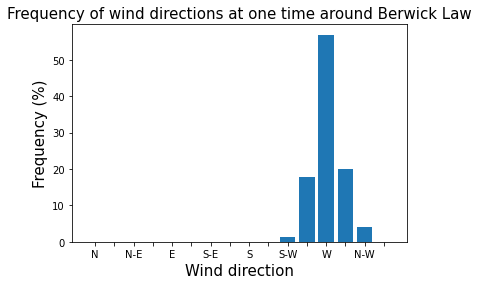

In [20]:
# Plotting the same information as on the windrose but as histograms
table = ax._info['table']
wd_freq = np.sum(table, axis=0)
plt.bar(np.arange(16), wd_freq, align='center')

# Customising the x axis labels
xlabels = ('N','','N-E','','E','','S-E','','S','','S-W','','W','','N-W','')
xticks=np.arange(16)
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xlabels)

# Customising the plot
plt.xlabel('Wind direction', size=15)
plt.ylabel('Frequency (%)', size=15)
plt.title('Frequency of wind directions at one time around Berwick Law', size=15)
plt.show()

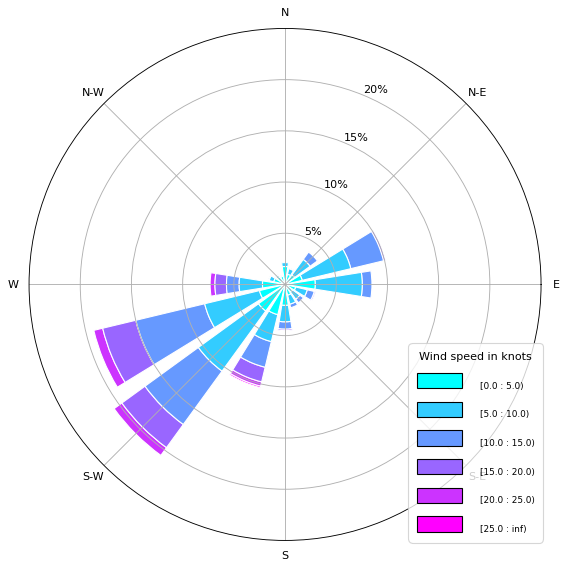

In [21]:
# Gogarbank

## Load in data from Gogarbank
gogarbank = pd.read_csv('data/wind-obs_edinburgh-gogarbank_2014.csv')
gogarbank[gogarbank['mean_wind_speed'] ==-999] = np.NaN
gogarbank[gogarbank['mean_wind_dir']==-999] = np.NaN
wsg = gogarbank['mean_wind_speed'] # Wind speeds in knots
wdg = gogarbank['mean_wind_dir'] # Wind directions (angle from N)

## Creating the windrose axis - x-axis (theta axis) is wind directions
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]                   
ax = WindroseAxes.from_ax(theta_labels=new_labels)

## Plotting the speeds and directions on the windrose
ax.bar(wdg, wsg, normed=True, opening=0.8, edgecolor='white',
      bins=np.arange(0, 30, 5), cmap=cm.cool)

## y axis (r axis) is thefrequency of a certain wind direction in percent
ax.set_ylim(0,25)
ax.set_yticks(np.arange(0, 25, 5))
ax.set_yticklabels(['', '5%', '10%', '15%', '20%'], size=10)
ax.set_legend(title='Wind speed in knots', fontsize=20, loc='lower right')

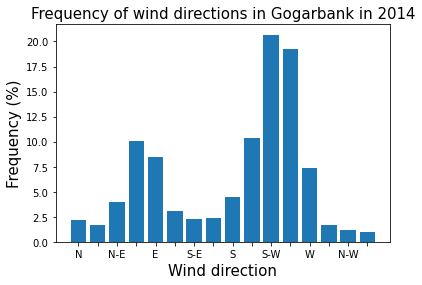

In [22]:
# Plotting the same information as on the windrose but as histograms
table = ax._info['table']
wd_freq = np.sum(table, axis=0)
plt.bar(np.arange(16), wd_freq, align='center')

# Customising the x axis labels
xlabels = ('N','','N-E','','E','','S-E','','S','','S-W','','W','','N-W','')
xticks=np.arange(16)
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xlabels)

# Customising the plot
plt.xlabel('Wind direction', size=15)
plt.ylabel('Frequency (%)', size=15)
plt.title('Frequency of wind directions in Gogarbank in 2014', size=15)
plt.show()

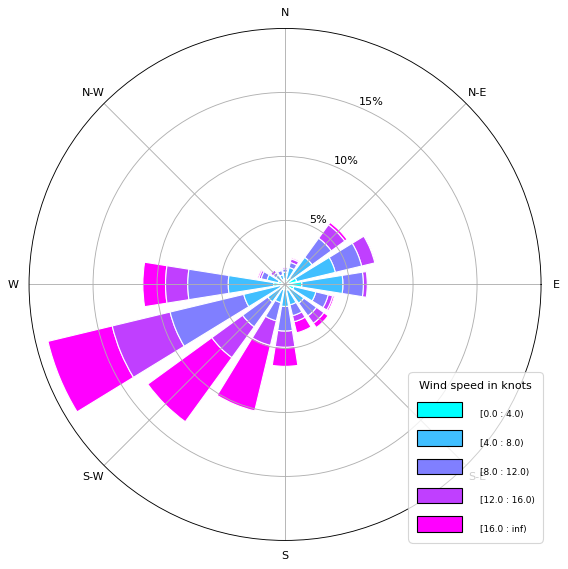

In [23]:
# Blackford hill

## Load in data from Blackford hill
blackford = pd.read_csv('data/wind-obs_edinburgh-blackford-hill_2014.csv')
blackford[blackford['mean_wind_speed'] ==-999] = np.NaN
wsb = blackford['mean_wind_speed'] # Wind speeds in knots
wdb = blackford['mean_wind_dir'] # Wind directions (angle from N)

## Creating the windrose axis - x-axis (theta axis) is wind directions
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]                   
ax = WindroseAxes.from_ax(theta_labels=new_labels)

## Plotting the speeds and directions on the windrose
ax.bar(wdb, wsb, normed=True, opening=0.8, edgecolor='white',
       bins=np.arange(0, 20, 4), cmap=cm.cool)

## y axis (r axis) is thefrequency of a certain wind direction in percent
ax.set_ylim(0,20)
ax.set_yticks(np.arange(0, 20, 5))
ax.set_yticklabels(['', '5%', '10%', '15%'], size=10)
ax.set_legend(title='Wind speed in knots',fontsize=20, loc='lower right')

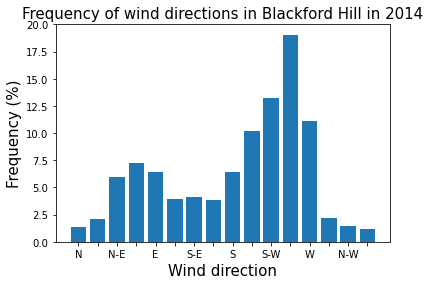

In [24]:
# Plotting the same information as on the windrose but as histograms
table = ax._info['table']
wd_freq = np.sum(table, axis=0)
plt.bar(np.arange(16), wd_freq, align='center')

# Customising the x axis labels
xlabels = ('N','','N-E','','E','','S-E','','S','','S-W','','W','','N-W','')
xticks=np.arange(16)
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xlabels)

# Customising the plot
plt.xlabel('Wind direction', size=15)
plt.ylabel('Frequency (%)', size=15)
plt.title('Frequency of wind directions in Blackford Hill in 2014', size=15)
plt.show()

## Seasonal trend for the wind direction and wind speed at Gogarbank

The wind data from 2014 to 2019 was analysed to see if there were months where a westerly wind was more likely. Gogarbank data was used as it is a flat site suroounded by fields (airport), so it would less likely be influenced by turbulence around hills and wind tunnels.

The results show that on average the wind is southwesterly but with more westerly winds in the winter months. Stronger winds are also more common in the winter, leading to better conditions for the measurements. The mean wind speeds are still quite low in the winter. Therefore, this seasonal analysis is not enough to base the date of the measurements on, current local weather forecasts would need to be monitored. For the fieldwork, strong westerly winds would likely produce the best quality of wind data (strong enough for anemometer to measure).

In [25]:
# Read in the files for gogarbank wind data
dates = ['2015', '2016', '2017', '2018', '2019']
data = pd.DataFrame()

# Looping over files 2015-2019 (deleted last line but not the information in the first 79 lines)
for i in dates:
    df=pd.read_csv('data/wind-obs_edinburgh-gogarbank_' + i + '.csv', skiprows=79, parse_dates=True, index_col='ob_end_time')
    data = data.append(df)

# Adding the 2014 data
gogarbank = pd.read_csv('data/wind-obs_edinburgh-gogarbank_2014.csv', parse_dates=True, index_col='ob_end_time')
data = data.append(gogarbank)

# Substituting NaN values to -999
data[data['mean_wind_speed'] ==-999] = np.NaN # 1820 values
data[data['mean_wind_dir']==-999] = np.NaN # 1830 values

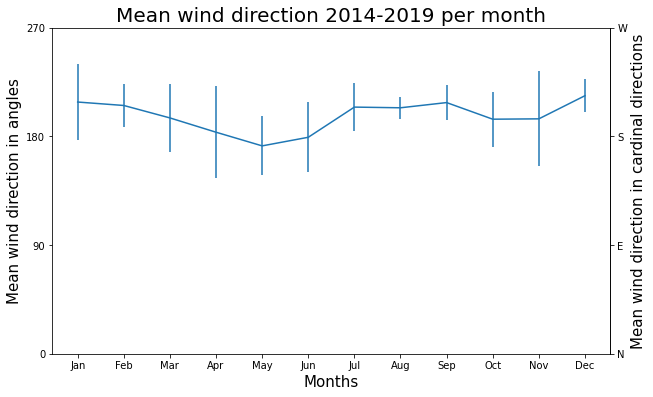

In [26]:
# Group wind direction data by months for all the years
winddir = data['mean_wind_dir']
monthlydir = winddir.groupby(by=[winddir.index.month, winddir.index.year]).mean()

# Finding the mean and standard deviation for each month
meandir = np.empty(12)
errordir = np.empty(12)
for i in range(12):
    meandir[i] = monthlydir[i+1].mean()
    errordir[i] = monthlydir[i+1].std()

# Plotting the mean wind direction per month with errorbars
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(np.arange(1,13,1),meandir, yerr=errordir)

# Customising the plot
ax.set_ylabel('Mean wind direction in angles', size=15)
ax.set_yticks(np.arange(0,360, 90))
ax.set_xlabel('Months', size=15)
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Mean wind direction 2014-2019 per month', size=20)

# Create secondary axis for cardinal directions
secaxy = ax.secondary_yaxis('right')
secaxy.set_ylabel('Mean wind direction in cardinal directions', size=15)
secaxy.set_yticks(np.arange(0,360, 90))
secaxy.set_yticklabels(['N', 'E', 'S', 'W'])
plt.show()

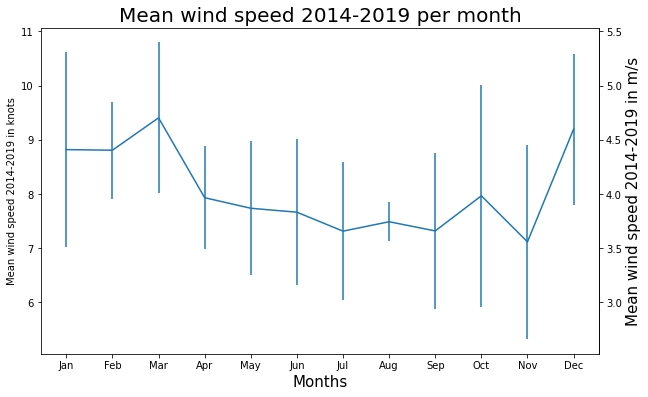

In [27]:
# Group wind speed data by months for all the years
windspeed = data['mean_wind_speed']
monthlyspeed = windspeed.groupby(by=[windspeed.index.month, windspeed.index.year]).mean()

# Finding the mean and standard deviation for each month
meanspeed = np.empty(12)
errorspeed = np.empty(12)
for i in range(12):
    meanspeed[i] = monthlyspeed[i+1].mean()
    errorspeed[i] = monthlyspeed[i+1].std()

# Plotting the mean wind speed per month with errorbars in knots
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(np.arange(1,13,1),meanspeed, yerr=errorspeed)

# Customising the plot
ax.set_ylabel('Mean wind speed 2014-2019 in knots')
ax.set_xlabel('Months', size=15)
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Mean wind speed 2014-2019 per month', size=20)

# Create secondary axis for wind speed in m/s
def knotstoms(x):
    return 0.5*x
def mstoknots(x):
    return 2*x
secaxy = ax.secondary_yaxis('right', functions=(knotstoms, mstoknots))
secaxy.set_ylabel('Mean wind speed 2014-2019 in m/s', size=15)
plt.show()